# Bayesian Parametric Regression

    Notebook version: 1.6 (Sep 29, 2024)

    Author: Jerónimo Arenas García (jarenas@tsc.uc3m.es)
            Jesús Cid-Sueiro (jesus.cid@uc3m.es)

    Changes: v.1.0 - First version
             v.1.1 - ML Model selection included
             v.1.2 - Some typos corrected
             v.1.3 - Rewriting text, reorganizing content, some exercises.
             v.1.4 - Revised introduction
             v.1.5 - Revised notation. Solved exercise 5
             v.1.6 - Eq. citation and numbering, revised Secs. 5-6, simplified code, predictive mean and variance defined, shaded exercises.
    
    Pending changes: * Include regression on the stock data

In [17]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 
from IPython import display
 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io       # To read matlab files
import pylab
import time

from sklearn.preprocessing import PolynomialFeatures


## A quick note on the mathematical notation

In this notebook we will make extensive use of probability distributions.  In general, we will use letter $p$ for probability density functions (pdf). When necessary, we will use, capital subindices to make the random variable explicit. For instance, $p_{{\bf X}, S}({\bf x}, s)$ would be the joint pdf of random variables ${\bf X}$ and $S$ at values ${\bf x}$ and $s$, respectively. 

However, to avoid a notation overload, we will omit subindices when they are clear from the context. For instance, we will use $p({\bf x}, s)$ instead of $p_{{\bf X}, S}({\bf x}, s)$.

Finally, we will use notation ${\bf U} \sim {\cal N}({\bf m}, {\bf V})$ to express that ${\bf U}$ is a Gaussian random variable with mean ${\bf m}$ and variance matrix ${\bf V}$

## 1. Model-based parametric regression

### 1.1. The regression problem.

Given an observation vector ${\bf x}$, the goal of the regression problem is to find a function $f({\bf x})$ providing *good* predictions about some unknown variable $s$. To do so, we assume that a set of *labelled* training examples, $\{{\bf x}_k, s_k\}_{k=0}^{K-1}$ is available. 

The predictor function should make good predictions for new observations ${\bf x}$ not used during training. In practice, this is tested using a second set (the *test set*) of labelled samples.

### 1.2. Model-based parametric regression

**Model-based regression** methods assume that all data in the training and test dataset have been generated by some stochastic process. In **parametric regression**, we assume that the probability distribution generating the data has a known parametric form, but the values of some parameters are unknown. 

In particular, in this notebook we will assume the target variables in all pairs $({\bf x}_k, s_k)$ from the training and test sets have been generated independently from some posterior distribution $p(s| {\bf x}, {\bf w})$, were ${\bf w}$ is some unknown parameter. The training dataset is used to estimate ${\bf w}$. 

<img src="figs/ParametricReg.png" width=300>


### 1.3. Model assumptions

In order to estimate ${\bf w}$ from the training data in a mathematicaly rigorous and compact form let us group the target variables into a vector
$$
{\bf s} = \left(s_0, \dots, s_{K-1}\right)^\top
$$
and the input vectors into a matrix
$$
{\bf X} = \left({\bf x}_0, \dots, {\bf x}_{K-1}\right)^\top
$$

We will make the following **assumptions**:

   * A1. All samples in ${\cal D}$ have been generated by the same distribution, $p({\bf x}, s \mid {\bf w})$
   * A2. Input variables ${\bf x}$ do not depend on ${\bf w}$. This implies that
$$
p({\bf X} \mid {\bf w}) = p({\bf X})
$$
   * A3. Targets $s_0, \dots, s_{K-1}$ are statistically independent, given ${\bf w}$ and the inputs ${\bf x}_0,\ldots, {\bf x}_{K-1}$, that is:
$$
p({\bf s} \mid {\bf X}, {\bf w}) = \prod_{k=0}^{K-1} p(s_k \mid {\bf x}_k, {\bf w})
$$
   

## 2. Bayesian inference.

### 2.1. The Bayesian approach

The main idea of **Bayesian inference** is the following: assume we want to estimate some unknown variable $U$ given an observed variable $O$. If $U$ and $O$ are random variables, we can describe the relation between $U$ and $O$ through the following functions:

   * **Prior distribution**: $p_U(u)$. It describes our uncertainty on the true value of $U$ before observing $O$.
   * **Likelihood function**: $p_{O \mid U}(o \mid u)$. It describes how the value of the observation is generated for a given value of $U$.
   * **Posterior distribution**: $p_{U|O}(u \mid o)$. It describes our uncertainty on the true value of $U$ once the true value of $O$ is observed.

The major component of the Bayesian inference is the posterior distribution. All Bayesian estimates are computed as some of its central statistics (e.g. the mean, the median or the mode), for instance

   * **Maximum A Posteriori (MAP) estimate**: $\qquad{\widehat{u}}_{\text{MAP}} = \arg\max_u p_{U \mid O}(u \mid o)$
   * **Minimum Mean Square Error (MSE) estimate**: $\qquad\widehat{u}_{\text{MSE}} = \mathbb{E}\{U \mid O=o\}$

The choice between the MAP or the MSE estimate may depend on practical or computational considerations. From a theoretical point of view, $\widehat{u}_{\text{MSE}}$ has some nice properties: it minimizes $\mathbb{E}\{(U-\widehat{u})^2\}$ among all possible estimates, $\widehat{u}$, so it is a natural choice. However, it involves the computation of an integral, which may not have a closed-form solution. In such cases, the MAP estimate can be a better choice.

The prior and the likelihood function are auxiliary distributions: if the posterior distribution is unknown, it can be computed from them using the Bayes rule:
\begin{equation*}
p_{U|O}(u \mid o) = \frac{p_{O|U}(o \mid u) \cdot p_{U}(u)}{p_{O}(o)}
\end{equation*}

In the next two sections we show that the Bayesian approach can be applied to both the prediction and the estimation problems.

### 2.2. Bayesian prediction under a known model

Assuming that the model parameters ${\bf w}$ are known, we can apply the Bayesian approach to predict ${\bf s}$ for an input ${\bf x}$. In that case, we can take

   * Unknown variable: ${\bf s}$, and
   * Observations: ${\bf x}$

an the Bayesian estimates become:

* Maximum A Posterior (MAP): 
<a id="eq1"></a>
\begin{align}\tag{1}
\qquad\widehat{s}_{\text{MAP}} = \arg\max_s p(s| {\bf x}, {\bf w})
\end{align}
* Minimum Mean Square Error (MSE): 
<a id="eq2"></a>
\begin{align}\tag{2}
\qquad\widehat{s}_{\text{MSE}} = \mathbb{E}\{S |{\bf x}, {\bf w}\}
\end{align}

<div style="background-color:  Gainsboro; padding: 10px; padding-left: 40px; width: calc(100% - 60px)">

#### Exercise 1:

Assuming 
$$p(s\mid x, w) = \frac{s}{w x^2} \exp\left({-\frac{s^2}{2 w x^2}}\right), \qquad s \geq 0,
$$
compute the MAP and MSE predictions of $s$ given $x$ and $w$.
</div>

#### Solution:
<SOL>

\begin{align*}
\widehat{s}_\text{MAP} 
   &= \arg\max_s \left\{\frac{s}{w x^2} \exp\left({-\frac{s^2}{2 w x^2}}\right) \right\} \\
   &= \arg\max_s \left\{\log(s) - \log(w x^2) -\frac{s^2}{2 w x^2} \right\}     \\
   &= \sqrt{w}x
\end{align*}
where the last step results from maximizing by differentiation.

\begin{align*}
\widehat{s}_\text{MSE} 
   &= \mathbb{E}\{s | x, w\}   \\
   &= \int_0^\infty \frac{s^2}{w x^2} \exp\left({-\frac{s^2}{2 w x^2}}\right)   \\
   &= \frac{1}{2} \int_{-\infty}^\infty \frac{s^2}{w x^2} \exp\left({-\frac{s^2}{2 w x^2}}\right)   \\
   &= \frac{\sqrt{2\pi}}{2\sqrt{w x^2}} \int_{-\infty}^\infty \frac{s^2}{\sqrt{2\pi w x^2}} \exp\left({-\frac{s^2}{2 w x^2}}\right)
\end{align*}

Noting that the last integral corresponds to the variance of a zero-mean Gaussian distribution, we get
\begin{align*}
\widehat{s}_\text{MSE} 
   &= \frac{\sqrt{2\pi}}{2\sqrt{w x^2}} w x^2   \\
   &= \sqrt{\frac{\pi w}{2}}x
\end{align*}

</SOL>


#### 2.2.1. The Gaussian case

The Gaussian model is one of the most widely used in Bayesian regression, mainly because it can be applied to arbitrarily non-linear and multidimensional regression problems. It is based on the assumption that the target variable and the observation are related through the stochastic equation
<a id="eq3"></a>
$$\tag{3} s = {\bf w}^\top{\bf z} + \varepsilon$$
where ${\bf z}=T({\bf x})$ is a known, possibly nonlinear transformation of the input variables, and $\varepsilon$ is a zero-mean Gaussian random variable
$$ \varepsilon \sim {\cal N}(0, \sigma_\varepsilon^2)
$$
that is independent of ${\bf w}$ and ${\bf x}$. This is equivalent to claim that
<a id="eq4"></a>
$$p(s|{\bf x}, {\bf w}) = 
    \frac{1}{\sqrt{2\pi}\sigma_\varepsilon}
    \exp\left(-\frac{(s-{\bf w}^\top{\bf z})^2}{2\sigma_\varepsilon^2}\right)
\tag{4}
$$

For a Gaussian distribution (and for any unimodal symetric distributions) the mean and the mode are the same and, thus, using Eqs. [(1)](#eq1) and [(2)](#eq2),
<a id="eq5"></a>
$$\tag{5}
\widehat{s}_\text{MAP} = \widehat{s}_\text{MSE} = {\bf w}^\top{\bf z}
$$
Such expression includes a linear regression model, where ${\bf z} = [1; {\bf x}]$, as well as any other non-linear model as long as it is <i>"linear in the parameters"</i>.

### 2.3. Bayesian Inference for Parameter Estimation

In a similar way, we can apply Bayesian inference to estimate the model parameters ${\bf w}$ from a given dataset, $\cal{D}$. In that case

   * the unknown variable is ${\bf w}$, and
   * the observation is $\cal{D} \equiv \{{\bf X}, {\bf s}\}$

so that

* Maximum A Posterior (MAP): 
<a id="eq6"></a>
$$\tag{6} \widehat{\bf w}_{\text{MAP}} = \arg\max_{\bf w} p({\bf w}| {\cal D})$$
* Minimum Mean Square Error (MSE): 
<a id="eq7"></a>
$$\tag{7} \widehat{\bf w}_{\text{MSE}} = \mathbb{E}\{{\bf W} | {\cal D}\}$$

## 3. Bayesian parameter estimation

NOTE: Since the training data inputs are known, all probability density functions and expectations in the remainder of this notebook will be conditioned on the data matrix, ${\bf X}$. To simplify the mathematical notation, from now on we will remove ${\bf X}$ from all conditions. For instance, we will write  $p({\bf s}|{\bf w})$ instead of  $p({\bf s}|{\bf w}, {\bf X})$, etc. Keep in mind that, in any case, all probabilities and expectations may depend on ${\bf X}$ implicitely.

Summarizing, the steps to design a Bayesian parametric regresion algorithm are the following:

1. Assume a parametric data model $p(s| {\bf x},{\bf w})$ and a prior distribution $p({\bf w})$.
2. Using the data model and the i.i.d. assumption, compute $p({\bf s}|{\bf w})$.
3. Applying the bayes rule, compute the posterior distribution $p({\bf w}|{\bf s})$.
4. Compute the MAP or the MSE estimate of ${\bf w}$ given ${\bf x}$.
5. Compute predictions using the selected estimate.


### 3.1. Bayesian Inference and Maximum Likelihood.

Applying the Bayes rule the MAP estimate in Eq. [(6)](#eq6) can be alternatively expressed as
<a id="eq8"></a>
\begin{align}
\widehat{\bf w}_{\text{MAP}}
   &= \arg\max_{\bf w} \frac{p({\cal D}| {\bf w}) \cdot p({\bf w})}{p({\cal D})} \nonumber \\
   &= \arg\max_{\bf w} \left\{p({\cal D}| {\bf w}) \cdot p({\bf w})\right\}
   \tag{8}
 \end{align}

By comparison, the ML (Maximum Likelihood) estimate has the form:
$$
\widehat{\bf w}_{\text{ML}} = \arg \max_{\bf w} p(\mathcal{D}|{\bf w})
$$

This shows that the MAP estimate takes into account the prior distribution on the unknown parameter.

Another advantage of the Bayesian approach is that it provides not only a point estimate of the unknown parameter, but a whole funtion, the posterior distribution, which encompasses our belief on the unknown parameter given the data. For instance, we can take second order statistics like the variance of the posterior distributions to measure the uncertainty on the true value of the parameter around the mean.

The MAP estimate can also be expressed as a function of the negative-log likelihood. Applying the minus logarithm over Eq. [(8)](#eq8), we get
\begin{align*}
\widehat{\bf w}_{\text{MAP}} 
   &= \arg\min_{\bf w} \left\{\text{NLL}(w) - \log\left(p({\bf w})\right)\right\}  \nonumber\\
   &= \arg\min_{\bf w} \left\{- \sum_{k=0}^{K-1}\log(p(s_k|x_k, {\bf w})) - \log\left(p({\bf w})\right)\right\}
\end{align*}


### 3.2. The prior distribution

Since each value of ${\bf w}$ determines a regression function, by stating a prior distribution over the weights we state also a prior distribution over the space of regression functions.

For instance, assume that the data likelihood follows the Gaussian model in Eq. [(3)](#eq3), with $T(x) = (1, x, x^2, x^3)$, i.e. the regression functions have the form
$$
w_0 + w_1 x + w_2 x^2 + w_3 x^3
$$

Each value of ${\bf w}$ determines a specific polynomial of degree 3. Thus, the prior distribution over ${\bf w}$ describes which polynomials are more likely before observing the data.

For instance, assume a Gaussian prior with zero mean and variance ${\bf V}_p$, i.e.,
$$
p({\bf w}) = \frac{1}{(2\pi)^{D/2} |{\bf V}_p|^{1/2}} 
              \exp \left(-\frac{1}{2} {\bf w}^\intercal {\bf V}_{p}^{-1}{\bf w} \right)
$$
where $D$ is the dimension of ${\bf w}$. To abbreviate, we will also express this as
$${\bf w} \sim {\cal N}\left({\bf 0},{\bf V}_{p} \right)$$
The following code samples ${\bf w}$ according to this distribution for ${\bf V}_p = 0.002 \, {\bf I}$, and plots the resulting polynomial over the scatter plot of an arbitrary dataset.

You can check the effect of modifying the variance of the prior distribution.

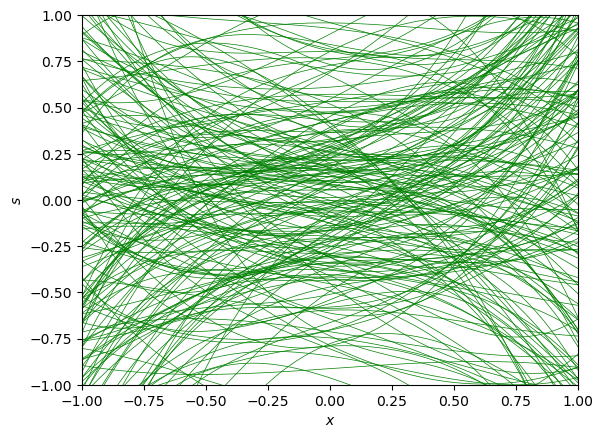

In [18]:
n_grid = 200
degree = 3
nplots = 200

# Prior distribution parameters
mean_w = np.zeros((degree + 1,))
v_p = 0.2     ### Try increasing this value
var_w = v_p * np.eye(degree+1)

xmin = -1
xmax = 1
X_grid = np.linspace(xmin, xmax, n_grid)

fig = plt.figure()
ax = fig.add_subplot(111)

for k in range(nplots):
    
    #Draw weigths fromt the prior distribution
    w_iter = np.random.multivariate_normal(mean_w, var_w)
    S_grid_iter = np.polyval(w_iter, X_grid)
    ax.plot(X_grid, S_grid_iter, 'g-', lw=0.5)

ax.set_xlim(xmin, xmax)
ax.set_ylim(-1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$s$')
plt.show()

The data observation will modify our belief about the true data model according to the posterior distribution. In the following we will analyze this in a Gaussian case.

## 4. Bayesian regression for a Gaussian model.

We will apply the above steps to derive a Bayesian regression algorithm for a Gaussian model.

### 4.1. Step 1: The Gaussian model.

Let us assume that the likelihood function is given by the Gaussian model in Eq. [(3)](#eq3)

$$
s~|~{\bf w} \sim {\cal N}\left({\bf z}^\top{\bf w}, \sigma_\varepsilon^2 \right)
$$

Assume, also, that the prior is Gaussian

$$
{\bf w} \sim {\cal N}\left({\bf 0},{\bf V}_{p} \right)
$$

### 4.2. Step 2: Complete data likelihood

Using the assumptions A1, A2 and A3 (see Notebook about ML regression), it can be shown that

$$
{\bf s}~|~{\bf w} \sim {\cal N}\left({\bf Z}{\bf w},\sigma_\varepsilon^2 {\bf I} \right)
$$
that is
$$
p({\bf s}| {\bf w})
    = \frac{1}{\left(\sqrt{2\pi}\sigma_\varepsilon\right)^K}
      \exp\left(-\frac{1}{2\sigma_\varepsilon^2}\|{\bf s}-{\bf Z}{\bf w}\|^2\right)
$$



### 4.3. Step 3: Posterior weight distribution

The posterior distribution of the weights can be computed using the Bayes rule

$$p({\bf w}|{\bf s}) = \frac{p({\bf s}|{\bf w})~p({\bf w})}{p({\bf s})}$$

Since both $p({\bf s}|{\bf w})$ and $p({\bf w})$ follow a Gaussian distribution, we know also that the joint distribution and the posterior distribution of ${\bf w}$ given ${\bf s}$ are also Gaussian. Therefore,

$${\bf w}~|~{\bf s} \sim {\cal N}\left({\bf w}_\text{MSE}, {\bf V}_{\bf w}\right)$$

It can be shown that mean and the covariance matrix of the distribution are:
<a id="eq9"></a>
$$\tag{9} \boxed{{\bf V_w} = \left[\frac{1}{\sigma_\varepsilon^2} {\bf Z}^{\top}{\bf Z} 
                           + {\bf V}_p^{-1}\right]^{-1}}$$
<a id="eq10"></a>
$$\tag{10} \boxed{{\bf w}_\text{MSE} = {\sigma_\varepsilon^{-2}} {\bf V}_{\bf w} {\bf Z}^\top {\bf s}}$$

<div style="background-color:  Gainsboro; padding: 10px; padding-left: 40px; width: calc(100% - 60px)">

#### Exercise 2: 

Consider the dataset with one-dimensional inputs given by
</div>

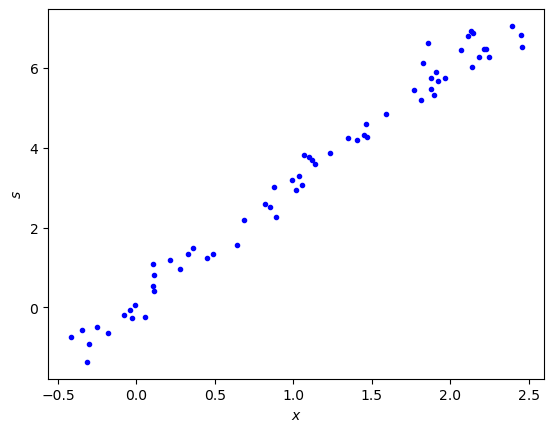

In [19]:
# True data parameters
w_true = 3
std_n = 0.4

# Generate the whole dataset
n_max = 64
X_tr = 3 * np.random.random((n_max,1)) - 0.5
S_tr =  w_true * X_tr + std_n * np.random.randn(n_max,1)

# Plot data
plt.figure()
plt.plot(X_tr, S_tr, 'b.')
plt.xlabel('$x$')
plt.ylabel('$s$')
plt.show()

<div style="background-color:  Gainsboro; padding: 10px; padding-left: 40px; width: calc(100% - 60px)">

Fit a Bayesian linear regression model assuming $z= x$ and
</div>

In [20]:
# Model parameters
sigma_eps = 0.4
mean_w = 1           # Since w is a scalar, mean_w is a scalar, too
sigma_p = 1e6
Var_p = sigma_p**2   # Since w is a scalar, Var_p is a scalar, too

<div style="background-color:  Gainsboro; padding: 10px; padding-left: 40px; width: calc(100% - 60px)">

(note that parameter $w$ is a scalar). 

To do so, compute the posterior weight distribution using the first $k$ samples in the complete dataset, for $k = 1,2,4,8,\ldots 128$. Draw all these posteriors along with the prior distribution in the same plot.

</div>

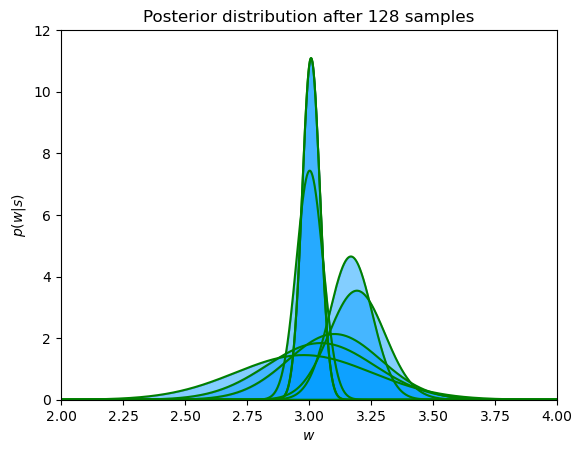

In [21]:
# No. of points to analyze
n_points = [1, 2, 4, 8, 16, 32, 64, 128]

# Prepare plots
w_grid = np.linspace(2, 4, 5000)   # Sample the w axis
plt.figure()

# Compute the prior distribution over the grid points in w_grid
# p = <FILL IN>
p = 1.0/(sigma_p * np.sqrt(2*np.pi)) * np.exp(-(w_grid**2) / (2*sigma_p**2))
plt.plot(w_grid, p,'g-')

for k in n_points:

    # Select the first k samples
    Zk = X_tr[:k, :]
    Sk = S_tr[:k]

    # Parameters of the posterior distribution
    # 1. Compute the posterior variance.
    #    (Make sure that the resulting variable, Var_w, is a scalar.)
    # Var_w = <FILL IN>
    Var_w = 1/ ((Zk.T @ Zk)[0][0]/(sigma_eps**2) + 1 / Var_p)
    
    # 2. Compute the posterior mean.
    #    (Make sure that the resulting variable, w_MSE, is a scalar)
    # w_MSE = <FILL IN>
    w_MSE = (Var_w * (Zk.T @ Sk)[0][0] / sigma_eps**2)

    # Compute the posterior distribution over the grid points in w_grid
    sigma_w = np.sqrt(Var_w)     # First we take a scalar standard deviation
    # p = <FILL IN>
    p = 1.0/(sigma_w*np.sqrt(2*np.pi)) * np.exp(-((w_grid-w_MSE)**2)/(2*sigma_w**2))
    
    plt.plot(w_grid, p,'g-')
    plt.fill_between(w_grid, 0, p, alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF',
                     linewidth=0.8, antialiased=True)
    plt.title(f'Posterior distribution after {k} samples')
    plt.xlim(w_grid[0], w_grid[-1])
    plt.ylim(0, 12)
    plt.xlabel('$w$')
    plt.ylabel('$p(w|s)$')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(2.0)

# Remove the temporary plots and fix the last one
display.clear_output(wait=True)
plt.show()

<div style="background-color:  Gainsboro; padding: 10px; padding-left: 40px; width: calc(100% - 60px)">

#### Exercise 3: 

Note that, in the example above, the model assumptions are correct: the target variables have been generated by a linear model with noise standard deviation `sigma_n` which is exactly equal to the value assumed by the model, stored in variable `sigma_eps`. Check what happens if we take `sigma_eps=4*sigma_n` or `sigma_eps=sigma_n/4`. 

* Does the algorithm fail in that cases?
* What differences can you observe with respect to the ideal case `sigma_eps=sigma_n`?
</div>

### 4.4. Step 4: Weight estimation.

Since the posterior weight distribution is Gaussian, both the MAP and the MSE estimates are equal to the posterior mean in Eq. [(10)](#eq10):

$$\widehat{\bf w}_\text{MAP} = \widehat{\bf w}_\text{MSE} = {\sigma_\varepsilon^{-2}} {\bf V}_{\bf w} {\bf Z}^\top {\bf s}$$

### 4.5. Step 5: Prediction

Using the MSE estimate, as in Eq. [(5)](#eq5), the final predictions are given by
$$
\widehat{s}_\text{MSE} =  \widehat{\bf w}_\text{MSE}^\top{\bf z}
$$

<div style="background-color:  Gainsboro; padding: 10px; padding-left: 40px; width: calc(100% - 60px)">

#### Exercise 4:

Plot the minimum MSE predictions of $s$ for inputs $x$ in the interval [-1, 3].

</div>

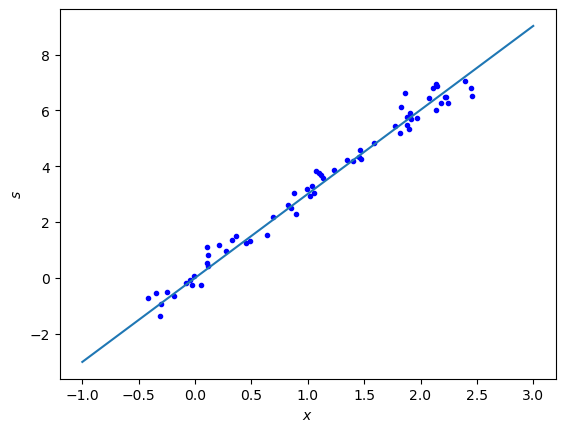

In [22]:
# Make grid on points (two points suffices to plot a line)
# x = <FILL IN>
x = np.array([-1.0, 3.0])
# Compute the predicted values for the points in the grid
# s_pred = <FILL IN>
s_pred = w_MSE * x

plt.figure()
plt.plot(X_tr, S_tr,'b.')
plt.plot(x, s_pred)
plt.xlabel('$x$')
plt.ylabel('$s$')
plt.show()


## 5. The predictive mean.

Up to here, we have followed a Bayesian approach in two steps:

  1. **Learning**: use $p({\bf w}\mid \cal D)$ to compute the MSE estimate, ${\bf w}_\text{MSE}$.
  2. **Prediction**: use $p(s \mid {\bf x}, {\bf w})$ to compute prediction $\hat{s}_\text{MSE} = \mathbb{E}\{s \mid {\bf x}, {\bf w}_\text{MSE}\}$

From a purely Bayesian perspective, if the goal is to predict $s$ (the unknown variable) for an input ${\bf x}$ and from the data in ${\cal D}$ (the observarions) we can use $p(s \mid {\bf x}, {\cal D})$ to compute estimate

\begin{align*}
\hat{s}^* &= \mathbb{E}\{s | {\bf x}, {\cal D} \}    \nonumber\\
          &= \int \mathbb{E}\{s | {\bf x}, {\bf w}, {\cal D} \} p({\bf w} \mid {\cal D}) d{\bf w}   \nonumber\\
          &= \int \mathbb{E}\{s | {\bf x}, {\bf w} \} p({\bf w} \mid {\cal D}) d{\bf w}   \tag{10}
\end{align*}
where we have applied the total expectation theorem in the second equality, and the independence assumption in the third one. The Bayesian estimate $\hat{s}^*$ is known as the **predictive mean**. 

From Eq. [(10)](#eq10), we can interpret the predictive mean as the aggregation of all possible estimates of the target variable (one per each ${\bf w}$), weighted by the posterior parameter distribution. That is, the purely Bayesian estimate integrates all possible predictors for a given model into a single one.

In general, $\hat{s}_\text{MSE}$ and $\hat{s}^*$ are different estimations, and $\hat{s}^*$ may be hard to compute. Fortunatelly, for the Gaussian model, they are equivalent, which can be shown by noting that 
\begin{align*}
\hat{s}^* &= \int_{\bf w} {\bf w}^\top{\bf z} p({\bf w} \mid {\cal D}) d{\bf w}  \\
          &= \left(\int_{\bf w} {\bf w} p({\bf w} \mid {\cal D}) d{\bf w}\right)^\top{\bf z}  \\
          &= {\bf w}_\text{MSE}^\top{\bf z} = \hat{s}_\text{MSE}  \\
\end{align*}



## 6. Posterior distribution of the target variable

One of the powerfull advantages of the Bayesian regression models is that they provide no only a prediction of the target variable, but a posterior distribution, which may be very informative of the quality of the predictions.

For the Gaussian model, the computation of the posterior distribution is straightforward. Eq. [(3)](#eq3) shows that the target variable is the sum of two components:
$$s = f + \varepsilon
$$
were $f = {\bf w}^\top{\bf z}$. The prediction error is a consequence of the randomness of the noise (which cannot be predicted, since it is independent on the date) and the uncertainty about ${\bf w}$, which can be reduced using data.

Since $f$ is a linear combination of random variables, it is a Gaussian random variable, with mean and variance
\begin{align*}
\mathbb{E}\{f \mid {\bf x}, {\cal D}\} 
   &= \mathbb{E}\{s \mid {\bf x}, {\cal D}\}  
    =  \widehat{\bf w}_\text{MSE} ^\top {\bf z}     \\
%   &=  {\sigma_\varepsilon^{-2}} {{\bf z}}^\top {\bf V}_{\bf w} {\bf Z}^\top {\bf s}   \\
\text{var}(f \mid {\bf x}, {\cal D}) 
   &= \mathbb{E}\{(f-{\bf w}_\text{MSE}^\top{\bf z})^2 \mid {\bf x}, {\cal D}\}   \\
   &= \mathbb{E}\{(({\bf w}-{\bf w}_\text{MSE})^\top{\bf z})^2 \mid {\bf x}, {\cal D}\}  \\
              &= {\bf z}^\top {\bf V}_{\bf w} {{\bf z}}
\end{align*}

Therefore, 
$$
f^*~|~{\bf s}, {\bf x} 
   \sim {\cal N}\left(\widehat{\bf w}_\text{MSE} ^\top {\bf z}, ~~ 
                      {\bf z}^\top {\bf V}_{\bf w} {\bf z} \right)
$$
and, since $s = f + \varepsilon$, which is the sum of independent variables the posterior distribution of the target variable  
$$
s ~|~{\bf s}, {\bf z}^* 
   \sim {\cal N}\left(\widehat{\bf w}_\text{MSE} ^\top {\bf z}, ~~
                      {\bf z}^\top {\bf V}_{\bf w} {\bf z} + \sigma_\varepsilon^2\right)
$$

The variance of the posterior distribution,
$$
v_{s|{\bf x}} = {\bf z}^\top {\bf V}_{\bf w} {\bf z} + \sigma_\varepsilon^2
$$
is known as the **predictive variance**, and it accounts for the variance of the target variable for each observation. Note that the noise variance cannot be reduced, but more data reduce the variance of the parameter estimates, and thus the predictive variance, too.

#### Example: random sinusoid

For the remainder of this notebook, we will illustrate the behavior of the Bayesian regression models by using a dataset of noisy samples from a sinusoidal signal.

In [23]:
# Configurable parameters
n_points = 20
frec = 3
std_n = 0.2     # Noise standard deviation
n_grid = 200

# Initialize random generator, for reproducibility
np.random.seed(42)

# Data generation
X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points, 1)

The figure shows the sampled points, and the underlying function (in the dotted curve).

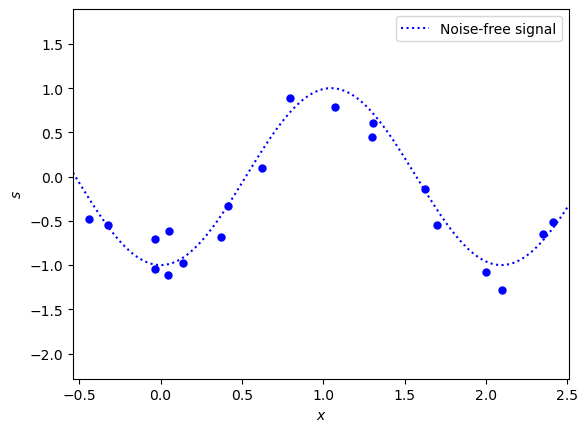

In [24]:
# Signal
xmin = np.min(X_tr) - 0.1
xmax = np.max(X_tr) + 0.1
X_grid = np.linspace(xmin, xmax, n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

# Plot data
plt.figure()
plt.plot(X_tr, S_tr,'b.',markersize=10)
# Plot noise-free function
plt.plot(X_grid, S_grid, 'b:', label='Noise-free signal')    

# we set some limits for the plot
ymin = np.min(S_tr) - 1
ymax = np.max(S_tr) + 1

# Set axes
plt.xlim(xmin, xmax), plt.xlabel('$x$')
plt.ylim(ymin, ymax), plt.ylabel('$s$')
plt.legend(loc='best')
plt.show()

Let us assume that the cosine form of the noise-free signal is unknown, and we assume a polynomial model with a high degree. The following code plots the ML estimate

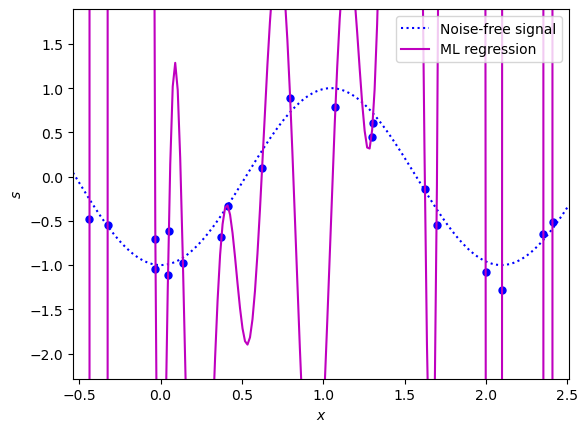

In [25]:
# Configurable parameters
degree = 18

# Compute matrix with training input data using sklearn
poly = PolynomialFeatures(degree=degree)

# Transform the training data
Z_tr = poly.fit_transform(X_tr)
# Compute the ML parameters
wML = np.linalg.lstsq(Z_tr, S_tr, rcond=1e-20)[0]

# Transform the samples in the grid.
X_grid_matrix = np.array([X_grid]).T     # Convert to 1-column matrix
Z_grid = poly.transform(X_grid_matrix)   # Transform the matrix

# Make predictions for the samples in the grid
# (and convert to a 1D array, as X_grid, for plotting)
S_grid_ML = (Z_grid @ wML).T[0]

# Plot data
fig = plt.figure()
plt.plot(X_tr, S_tr, 'b.', markersize=10)

# Plot noise-free function
plt.plot(X_grid, S_grid, 'b:', label='Noise-free signal')    
# Plot ML regression function
plt.plot(X_grid, S_grid_ML, 'm-', label='ML regression')    

# Set axis
plt.xlim(xmin, xmax), plt.xlabel('$x$')
plt.ylim(ymin, ymax), plt.ylabel('$s$')
plt.legend(loc='best')
plt.show()

When the degree of the polynomial is close to the size of the dataset, the ML regresion overfits the training data, and would produce a large prediction errors over an independent test set.

The following fragment of code computes the posterior weight distribution, draws random vectors from $p({\bf w}|{\bf s})$, and plots the corresponding regression curves along with the training points. Compare these curves with those extracted from the prior distribution of ${\bf w}$ and with the ML solution.

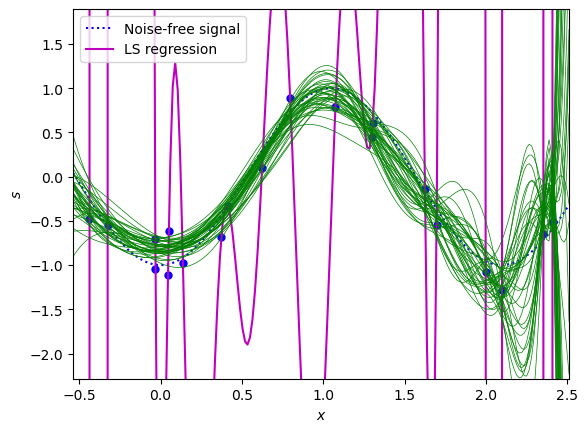

In [26]:
# Configurable parameters
nplots = 40
# Noise standard deviation
sigma_eps = 0.2
# Prior distribution parameters
mean_w = np.zeros((degree + 1,))
sigma_p = 2

# Compute posterior distribution parameters
Vp = sigma_p**2 * np.eye(degree + 1)
inv_Vp = 1 / sigma_p**2 * np.eye(degree + 1)
Vw = np.linalg.inv(inv_Vp + Z_tr.T @ Z_tr / (sigma_eps**2))
# This is to ensure that Var_w is symmetric, and does not deviate because of 
# numerical errors
Vw = (Vw + Vw.T) / 2
# Compute the posterior mean, and convert to 1D array
wMSE = Vw @ Z_tr.T @ S_tr / (sigma_eps**2)
wMSE = wMSE.T[0]

# Plot data
plt.figure()
plt.plot(X_tr, S_tr,'b.',markersize=10)
# Plot noise-free function
plt.plot(X_grid, S_grid, 'b:', label='Noise-free signal')    
# Plot ML regression function
plt.plot(X_grid, S_grid_ML, 'm-', label='LS regression')    

for k in range(nplots):    
    # Draw weights from the posterior distribution
    w_iter = np.random.multivariate_normal(wMSE, Vw)

    # Compute and plot predictions for the samples in the grid
    S_grid_iter = Z_grid @ w_iter
    plt.plot(X_grid, S_grid_iter, 'g-', lw=0.5)

# Set axis
plt.xlim(xmin, xmax), plt.xlabel('$x$')
plt.ylim(ymin, ymax), plt.ylabel('$s$')
plt.legend(loc='best')
plt.show()

As an alternative to the
The following fragment of code computes the posterior weight distribution, draws random vectors from $p({\bf w}|{\bf s})$, and plots the corresponding regression curves along with the training points. Compare these curves with those extracted from the prior distribution of ${\bf w}$ and with the LS solution.

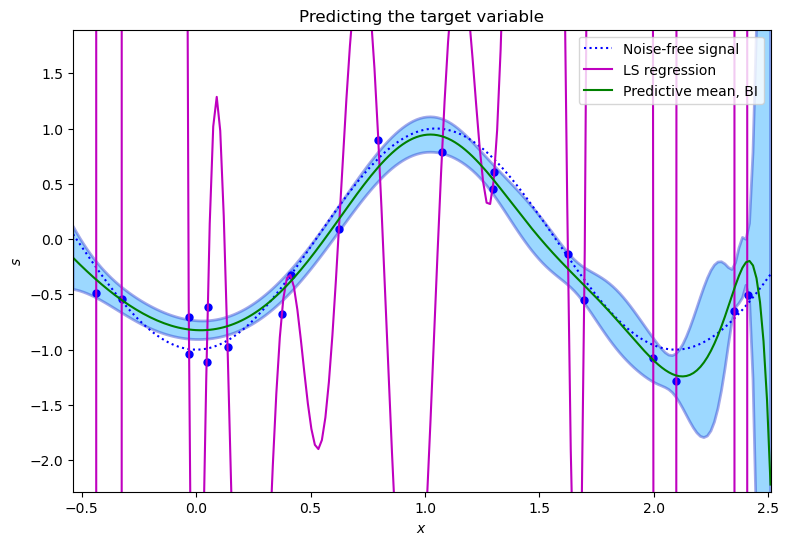

In [27]:
# Compute the posterior mean
S_grid_MSE = Z_grid @ wMSE

# Compute standard deviations of the posterior distribution for the samples in 
# the grid
Vsx = np.sum(Z_grid * (Z_grid @ Vw), axis=1)
std_x = np.sqrt(Vsx)

# Plot data
plt.figure(figsize=(9, 6))
plt.plot(X_tr, S_tr, 'b.', markersize=10)
# Plot true function
plt.plot(X_grid, S_grid, 'b:', label='Noise-free signal')    
# Plot LS regression function
plt.plot(X_grid, S_grid_ML, 'm-', label='LS regression')    

# Plot predictive mean for the Bayesian Inference
plt.plot(X_grid, S_grid_MSE,'g-',label='Predictive mean, BI')
# Plot confidence intervals for the Bayesian Inference
plt.fill_between(X_grid, S_grid_MSE-std_x, S_grid_MSE+std_x,
    alpha=0.4, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=2, antialiased=True)

# Set axis
plt.xlim(xmin, xmax), plt.xlabel('$x$')
plt.ylim(ymin, ymax), plt.ylabel('$s$')
plt.title('Predicting the target variable')
plt.legend(loc='best')
plt.show()

Not only do we obtain a better predictive model, but we also have confidence intervals (error bars) for the predictions.

<div style="background-color:  Gainsboro; padding: 10px; padding-left: 40px; width: calc(100% - 60px)">

#### Exercise 5:

Assume the dataset ${\cal{D}} = \left\{ x_k, s_k \right\}_{k=0}^{K-1}$ containing $K$ i.i.d. samples from a distribution
$$p(s|x,w) = w x \exp(-w x s), \qquad s>0,\quad x> 0,\quad w> 0$$

We model also our uncertainty about the value of $w$ assuming a prior distribution for $w$ following a Gamma distribution with parameters $\alpha>0$ and $\beta>0$.
$$
w \sim \text{Gamma}\left(\alpha, \beta \right) 
    = \frac{\beta^\alpha}{\Gamma(\alpha)} w^{\alpha-1} \exp\left(-\beta w\right), \qquad w>0
$$

Note that the mean and the mode of a Gamma distribution can be calculated in closed-form as
$$
\mathbb{E}\left\{w\right\}=\frac{\alpha}{\beta}; \qquad
$$
$$
\text{mode}\{w\} = \arg\max_w p(w) = \frac{\alpha-1}{\beta}
$$

**1.** Determine an expression for the likelihood function.

</div>

#### Solution:

[comment]: # (<SOL>)

\begin{align}
p({\bf s}| w) 
    &= \prod_{k=0}^{K-1} p(s_k|w, x_k) = \prod_{k=0}^{K-1} \left(w x_k \exp(-w x_k s_k)\right) \nonumber\\
    &= w^K \cdot \left(\prod_{k=0}^{K-1} x_k \right) \exp\left( -w \sum_{k=0}^{K-1} x_k s_k\right)
\end{align}

[comment]: # (</SOL>)


<div style="background-color:  Gainsboro; padding: 10px; padding-left: 40px; width: calc(100% - 60px)">

**2.** Determine the maximum likelihood coefficient,  $\widehat{w}_{\text{ML}}$.

</div>

#### Solution:

[comment]: # (<SOL>)

\begin{align}
\widehat{w}_{\text{ML}} 
    &= \arg\max_w w^K \cdot \left(\prod_{k=0}^{K-1} x_k \right) \exp\left( -w \sum_{k=0}^{K-1} x_k s_k\right)
    \\
    &= \arg\max_w \left(w^K \cdot \exp\left( -w \sum_{k=0}^{K-1} x_k s_k\right)\right)
    \\
    &= \arg\max_w \left(K \log(w) - w \sum_{k=0}^{K-1} x_k s_k \right)
    \\
    &= \frac{K}{\sum_{k=0}^{K-1} x_k s_k} 
\end{align}

[comment]: # (</SOL>)


<div style="background-color:  Gainsboro; padding: 10px; padding-left: 40px; width: calc(100% - 60px)">

**3.** Obtain the posterior distribution $p(w|{\bf s})$. Note that you do not need to calculate $p({\bf s})$ since the posterior distribution can be readily identified as another Gamma distribution.

</div>

#### Solution:

[comment]: # (<SOL>)

\begin{align}
p(w|{\bf s}) 
    &= \frac{p({\bf s}|w) p(w)}{p(s)}  \\
    &=  \frac{1}{p(s)} 
       \left(w^K \cdot \left(\prod_{k=0}^{K-1} x_k \right) \exp\left( -w \sum_{k=0}^{K-1} x_k s_k\right) \right)
       \left(\frac{\beta^\alpha}{\Gamma(\alpha)} w^{\alpha-1} \exp\left(-\beta w\right)\right)  \\
    &=  \frac{1}{p(s)} \frac{\beta^\alpha}{\Gamma(\alpha)} \left(\prod_{k=0}^{K-1} x_k \right) 
       \left(w^{K + \alpha - 1} \cdot 
             \exp\left( -w \left(\beta + \sum_{k=0}^{K-1} x_k s_k\right) \right) \right)
\end{align}
that is
$$
w \mid {\bf s} \sim Gamma\left(K+\alpha, \beta + \sum_{k=0}^{K-1} x_k s_k \right)
$$

[comment]: # (</SOL>)

<div style="background-color:  Gainsboro; padding: 10px; padding-left: 40px; width: calc(100% - 60px)">

**4.** Determine the MSE and MAP a posteriori estimators of $w$: $w_\text{MSE}=\mathbb{E}\left\{w|{\bf s}\right\}$ and $w_\text{MAP} = \max_w p(w|{\bf s})$.

</div>

#### Solution:

[comment]: # (<SOL>)
$$
w_{\text{MSE}} = \mathbb{E}\left\{w \mid {\bf s} \right\} 
               = \frac{K + \alpha}{\beta + \sum_{k=0}^{K-1} x_k s_k}
$$

$$
w_{\text{MAP}} = \text{mode}\{w\} = \arg\max_w p(w) = \frac{K + \alpha-1}{\beta + \sum_{k=0}^{K-1} x_k s_k}
$$

[comment]: # (</SOL>)


<div style="background-color:  Gainsboro; padding: 10px; padding-left: 40px; width: calc(100% - 60px)">

**5.** Compute the following estimators of $S$:

$\qquad\widehat{s}_1 = \mathbb{E}\{s|w_\text{ML},x\}$

$\qquad\widehat{s}_2 = \mathbb{E}\{s|w_\text{MSE},x\}$

$\qquad\widehat{s}_3 = \mathbb{E}\{s|w_\text{MAP},x\}$

</div>

#### Solution:

[comment]: # (<SOL>)
$$
\widehat{s}_1 = \mathbb{E}\{s|w_\text{ML},x\} = w_\text{ML} x
$$

$$
\widehat{s}_2 = \mathbb{E}\{s|w_\text{MSE},x\} = w_\text{MSE} x
$$

$$
\widehat{s}_3 = \mathbb{E}\{s|w_\text{MAP},x\} = w_\text{MAP} x
$$
    
[comment]: # (</SOL>)
    
    



## 7. Maximum evidence model selection

We have already addressed with Bayesian Inference the following two issues:

   - For a given degree, how do we choose the weights?
   
   - Should we focus on just one model, or can we use several models at once?
   
However, we still needed some assumptions: a parametric model (i.e., polynomial function and <i>a priori</i> degree selection) and several parameters needed to be adjusted.

Though we can recur to cross-validation, Bayesian inference opens the door to other strategies. 

   - We could argue that rather than keeping single selections of these parameters, we could use simultaneously several sets of parameters (and/or several parametric forms), and average them in a probabilistic way ... (like we did with the models)
   
   - We will follow a simpler strategy, selecting just the most likely set of parameters according to an ML criterion

### 7.1 Model evidence

The evidence of a model is defined as

$$L = p({\bf s}~|~{\cal M})$$

where ${\cal M}$ denotes the model itself and any free parameters it may have. For instance, for the polynomial model we have assumed so far, ${\cal M}$ would represent the degree of the polynomia, the variance of the additive noise, and the <i>a priori</i> covariance matrix of the weights

Applying the Theorem of Total probability, we can compute the evidence of the model as

$$L = \int p({\bf s}~|~{\bf f},{\cal M}) p({\bf f}~|~{\cal M}) d{\bf f} $$

For the linear model $f({\bf x}) = {\bf w}^\top{\bf z}$, the evidence can be computed as

$$L = \int p({\bf s}~|~{\bf w},{\cal M}) p({\bf w}~|~{\cal M}) d{\bf w} $$

It is important to notice that these probability density functions are exactly the ones we computed on the previous section. We are just making explicit that they depend on a particular model and the selection of its parameters. Therefore:

   - $p({\bf s}~|~{\bf w},{\cal M})$ is the likelihood of ${\bf w}$
   
   - $p({\bf w}~|~{\cal M})$ is the <i>a priori</i> distribution of the weights

### 7.2 Model selection via evidence maximization

   - As we have already mentioned, we could propose a prior distribution for the model parameters, $p({\cal M})$, and use it to infer the posterior. However, this can be very involved (usually no closed-form expressions can be derived)
   
   - Alternatively, maximizing the evidence is normally good enough
   
   $${\cal M}_\text{ML} = \arg\max_{\cal M} p(s~|~{\cal M})$$
   
Note that we are using the subscript 'ML' because the evidence can also be referred to as the likelihood of the model

### 7.3 Example: Selection of the degree of the polynomia

For the previous example we had (we consider a spherical Gaussian for the weights):

   - ${\bf s}~|~{\bf w},{\cal M}~\sim~{\cal N}\left({\bf Z}{\bf w},~\sigma_\varepsilon^2 {\bf I} \right)$
   
   - ${\bf w}~|~{\cal M}~\sim~{\cal N}\left({\bf 0},~\sigma_p^2 {\bf I} \right)$
   
In this case, $p({\bf s}~|~{\cal M})$ follows also a Gaussian distribution, and it can be shown that

   - $L = p({\bf s}~|~{\cal M}) = {\cal N}\left({\bf 0},\sigma_p^2 {\bf Z} {\bf Z}^\top+\sigma_\varepsilon^2 {\bf I} \right)$
   
If we just pursue the maximization of $L$, this is equivalent to maximizing the log of the evidence

$$\log(L) = -\frac{M}{2} \log(2\pi) -{\frac{1}{2}}\log\mid\sigma_p^2 {\bf Z} {\bf Z}^\top+\sigma_\varepsilon^2 {\bf I}\mid - \frac{1}{2} {\bf s}^\top \left(\sigma_p^2 {\bf Z} {\bf Z}^\top+\sigma_\varepsilon^2 {\bf I}\right)^{-1} {\bf s}$$

where $M$ denotes the length of vector ${\bf z}$ (the degree of the polynomia minus 1).
   
The following fragment of code evaluates the evidence of the model as a function of the degree of the polynomia

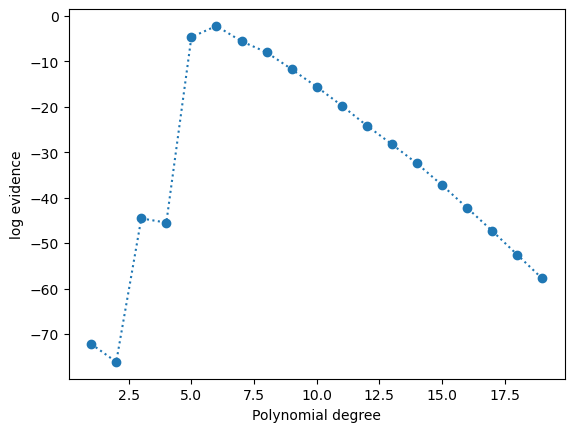

In [28]:
# Prior distribution parameters
max_degree = n_points - 1

# Evaluate the posterior evidence
logE = []
for deg in range(max_degree):
    Z_iter = Z_tr[:,:deg+1]
    ZZ = Z_iter @ Z_iter.T
    logE_iter = - (deg + 1) * np.log(2 * np.pi) / 2   \
                - np.log(np.linalg.det((sigma_p**2) * ZZ + (sigma_eps**2)*np.eye(n_points))) / 2   \
                - S_tr.T @ np.linalg.inv((sigma_p**2) * ZZ + (sigma_eps**2)*np.eye(n_points)) @ S_tr / 2
    logE.append(logE_iter[0, 0])

plt.plot(np.array(range(max_degree))+1, logE, ':o')
plt.xlabel('Polynomial degree')
plt.ylabel('log evidence')
plt.show()


In [29]:
degree = np.argmax(logE)   
print(f'The degree of the polynomial is {degree}')

The degree of the polynomial is 5


Let's train the model for the maximum degree

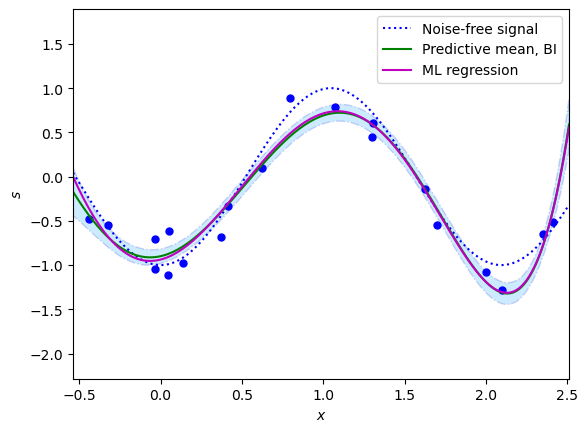

In [30]:
inv_Vp = np.eye(degree+1) / sigma_p**2

# Select transformed matrix up to the selected degree
Z = Z_tr[:, :(degree+1)]

# Compute posterior distribution parameters
Vw = np.linalg.inv(Z.T @ Z /(sigma_eps**2) + inv_Vp)
wMSE = (Vw @ Z.T @ S_tr / (sigma_eps**2)).T[0]

# Compute maximum likelihood solution for the selected degree
wML = np.linalg.lstsq(Z, S_tr, rcond=1e-20)[0]

# Compute ML and MSE predictions for the grid inputs
Z_grid_degree = Z_grid[:, :(degree+1)]
S_grid_ML = Z_grid_degree @ wML
S_grid_MSE = Z_grid_degree @ wMSE

# Compute standard deviations of the posterior distribution for the samples in 
# the grid
Vsx = np.sum(Z_grid_degree * (Z_grid_degree @ Vw), axis=1)
std_x = np.sqrt(Vsx)

# Plot data
fig = plt.figure()
plt.plot(X_tr, S_tr,'b.',markersize=10)
# Plot true function
plt.plot(X_grid, S_grid, 'b:', label='Noise-free signal')    
plt.plot(X_grid, S_grid_MSE,'g-',label='Predictive mean, BI')

plt.fill_between(X_grid, S_grid_MSE - std_x, S_grid_MSE + std_x,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=1, linestyle='dashdot', antialiased=True)

#We plot also the least square solution
plt.plot(X_grid, S_grid_ML,'m-',label='ML regression')
    
plt.xlim(xmin, xmax), plt.xlabel('$x$')
plt.ylim(ymin, ymax), plt.ylabel('$s$')
plt.legend(loc='best')
plt.show()

We can check, that now the model also seems quite appropriate for ML regression, but keep in mind that selection of such parameter was itself carried out using Bayesian inference.